# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering` and `DBSCAN`
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
X_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
delimiter = ','
X0 = pd.read_csv(X_url, delimiter=delimiter)
X0.shape

(440, 8)

In [3]:
X0.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

## 2. Observe the data distributions

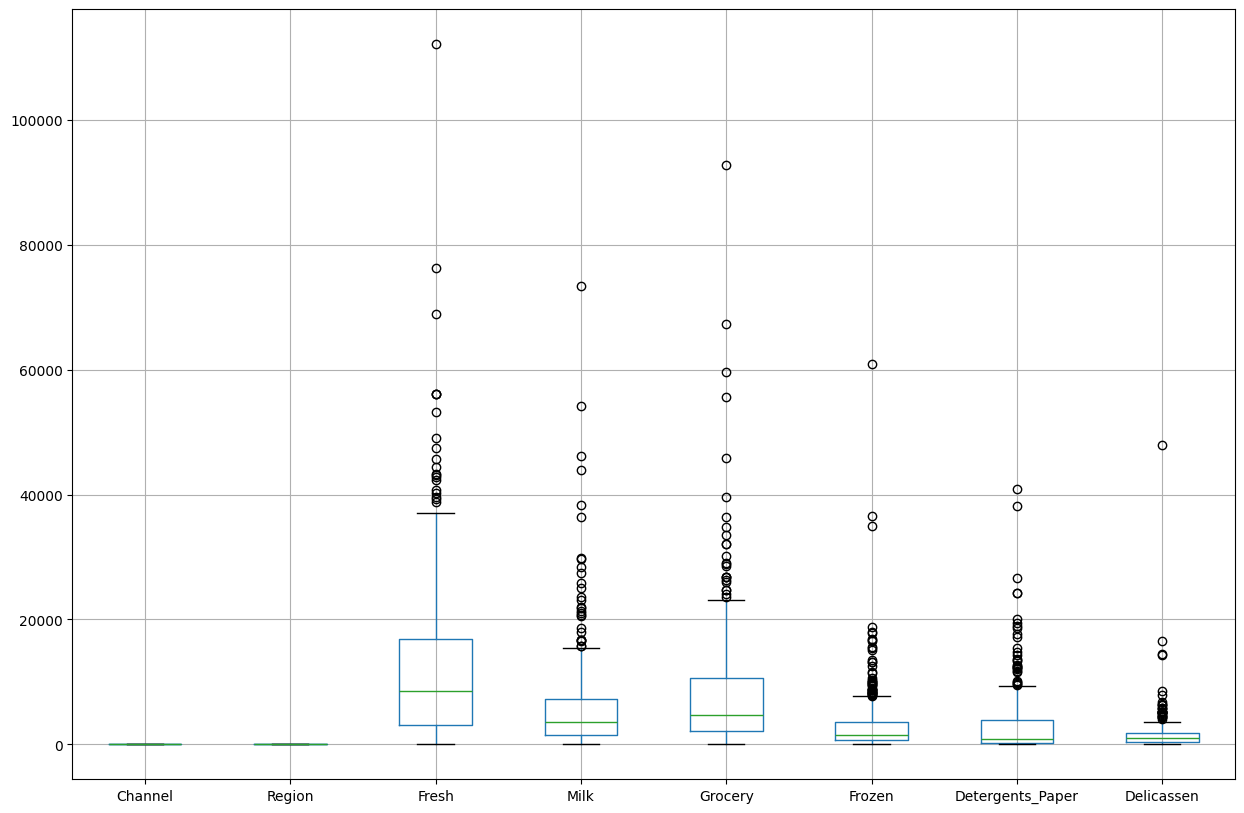

In [4]:
X0.boxplot(figsize=(15,10));

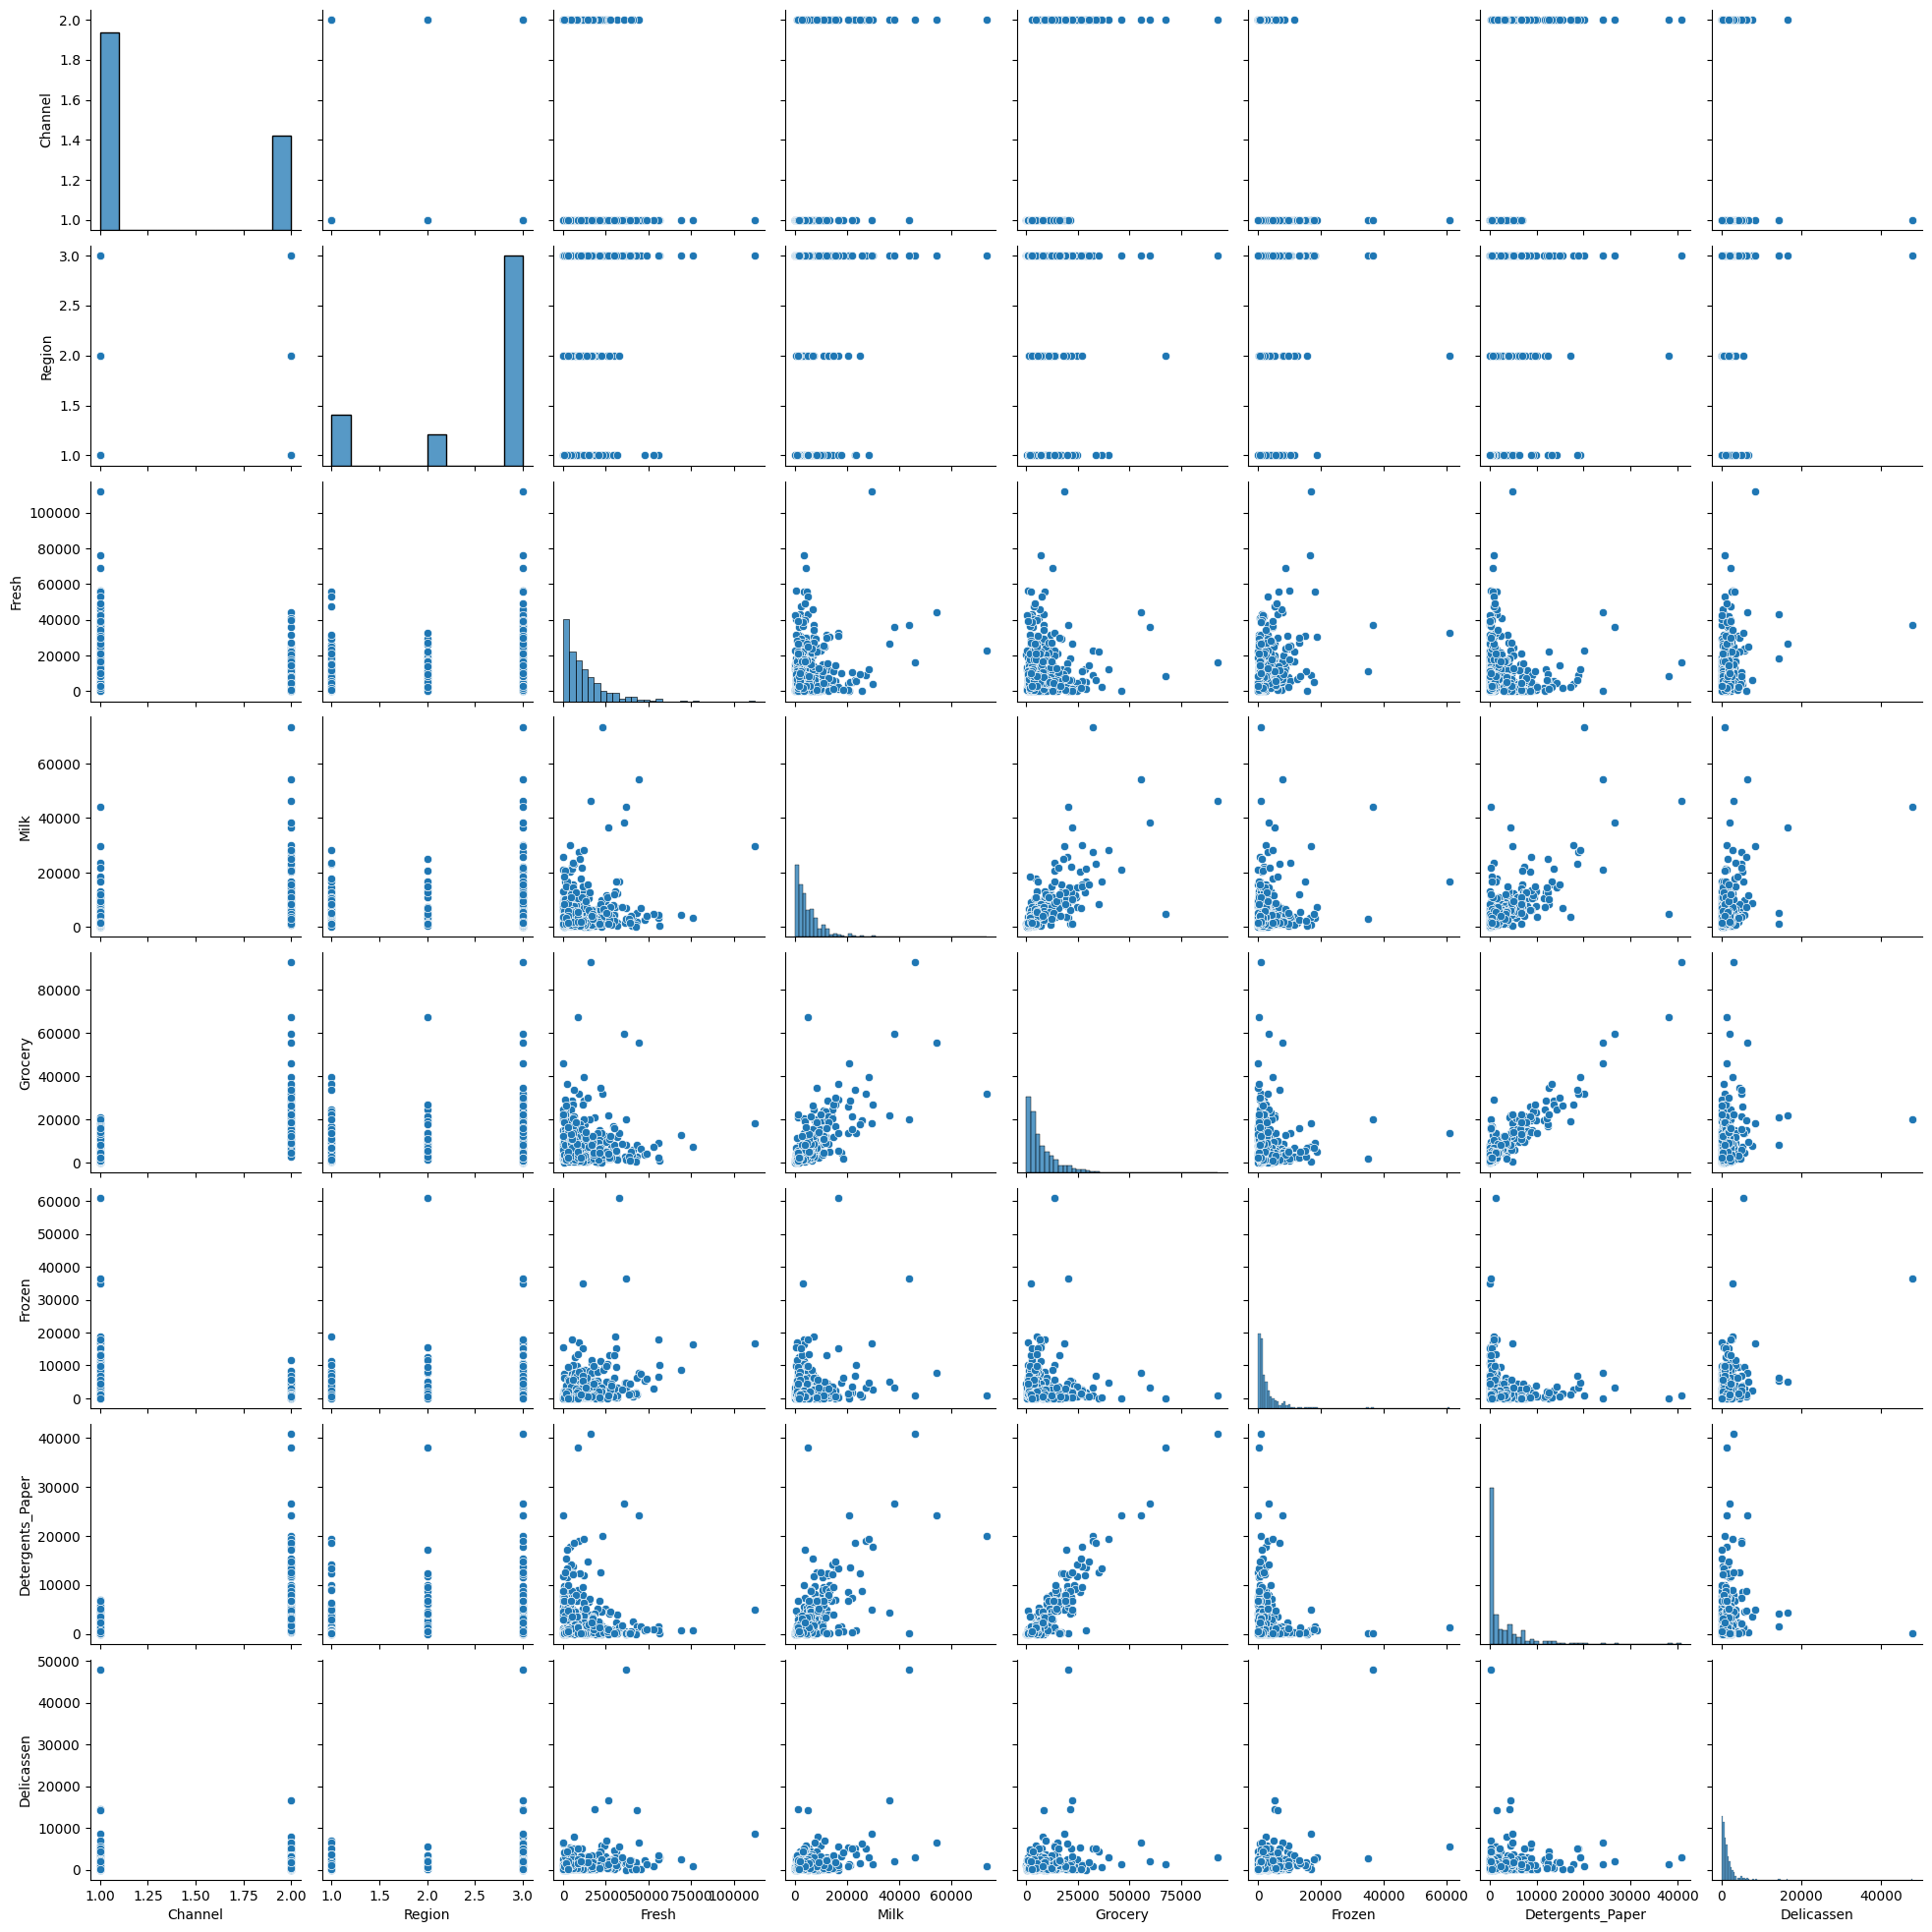

In [5]:
sns.pairplot(X0);
plt.show()

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1`

In [6]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
X_pt = pd.DataFrame(pt.fit_transform(X0.iloc[:,2:]),columns=X0.columns[2:])
X_trasf = pd.concat([X0.iloc[:,:2],X_pt],axis=1)
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X_trasf), columns = X_trasf.columns)
X.head()

Channel  Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0      1.0     1.0  0.501828  0.667606  0.625238  0.208640          0.649941   
1      1.0     1.0  0.414266  0.670028  0.655690  0.458800          0.674852   
2      1.0     1.0  0.400077  0.653586  0.627297  0.499856          0.682752   
3      0.0     1.0  0.509368  0.369264  0.553550  0.636716          0.461095   
4      1.0     1.0  0.604755  0.580657  0.618985  0.566470          0.601884   

   Delicassen  
0    0.412016  
1    0.445663  
2    0.654292  
3    0.446485  
4    0.590255

Show the result of the transformation

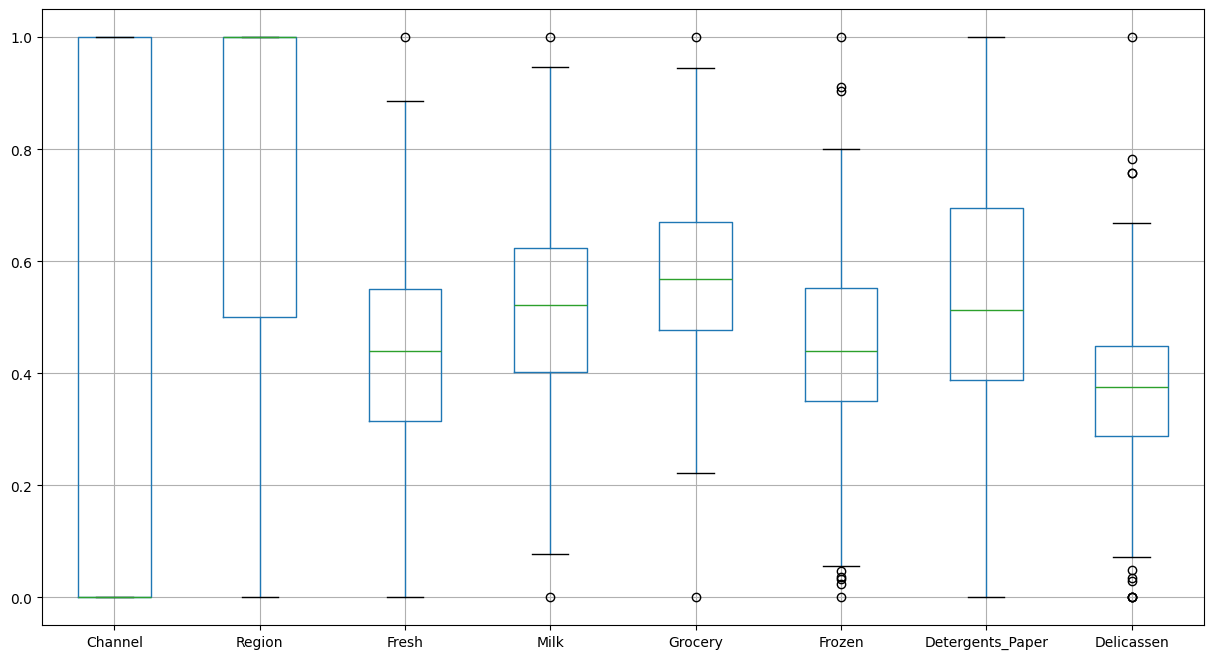

In [7]:
X.boxplot(figsize=(15,8));
plt.show()

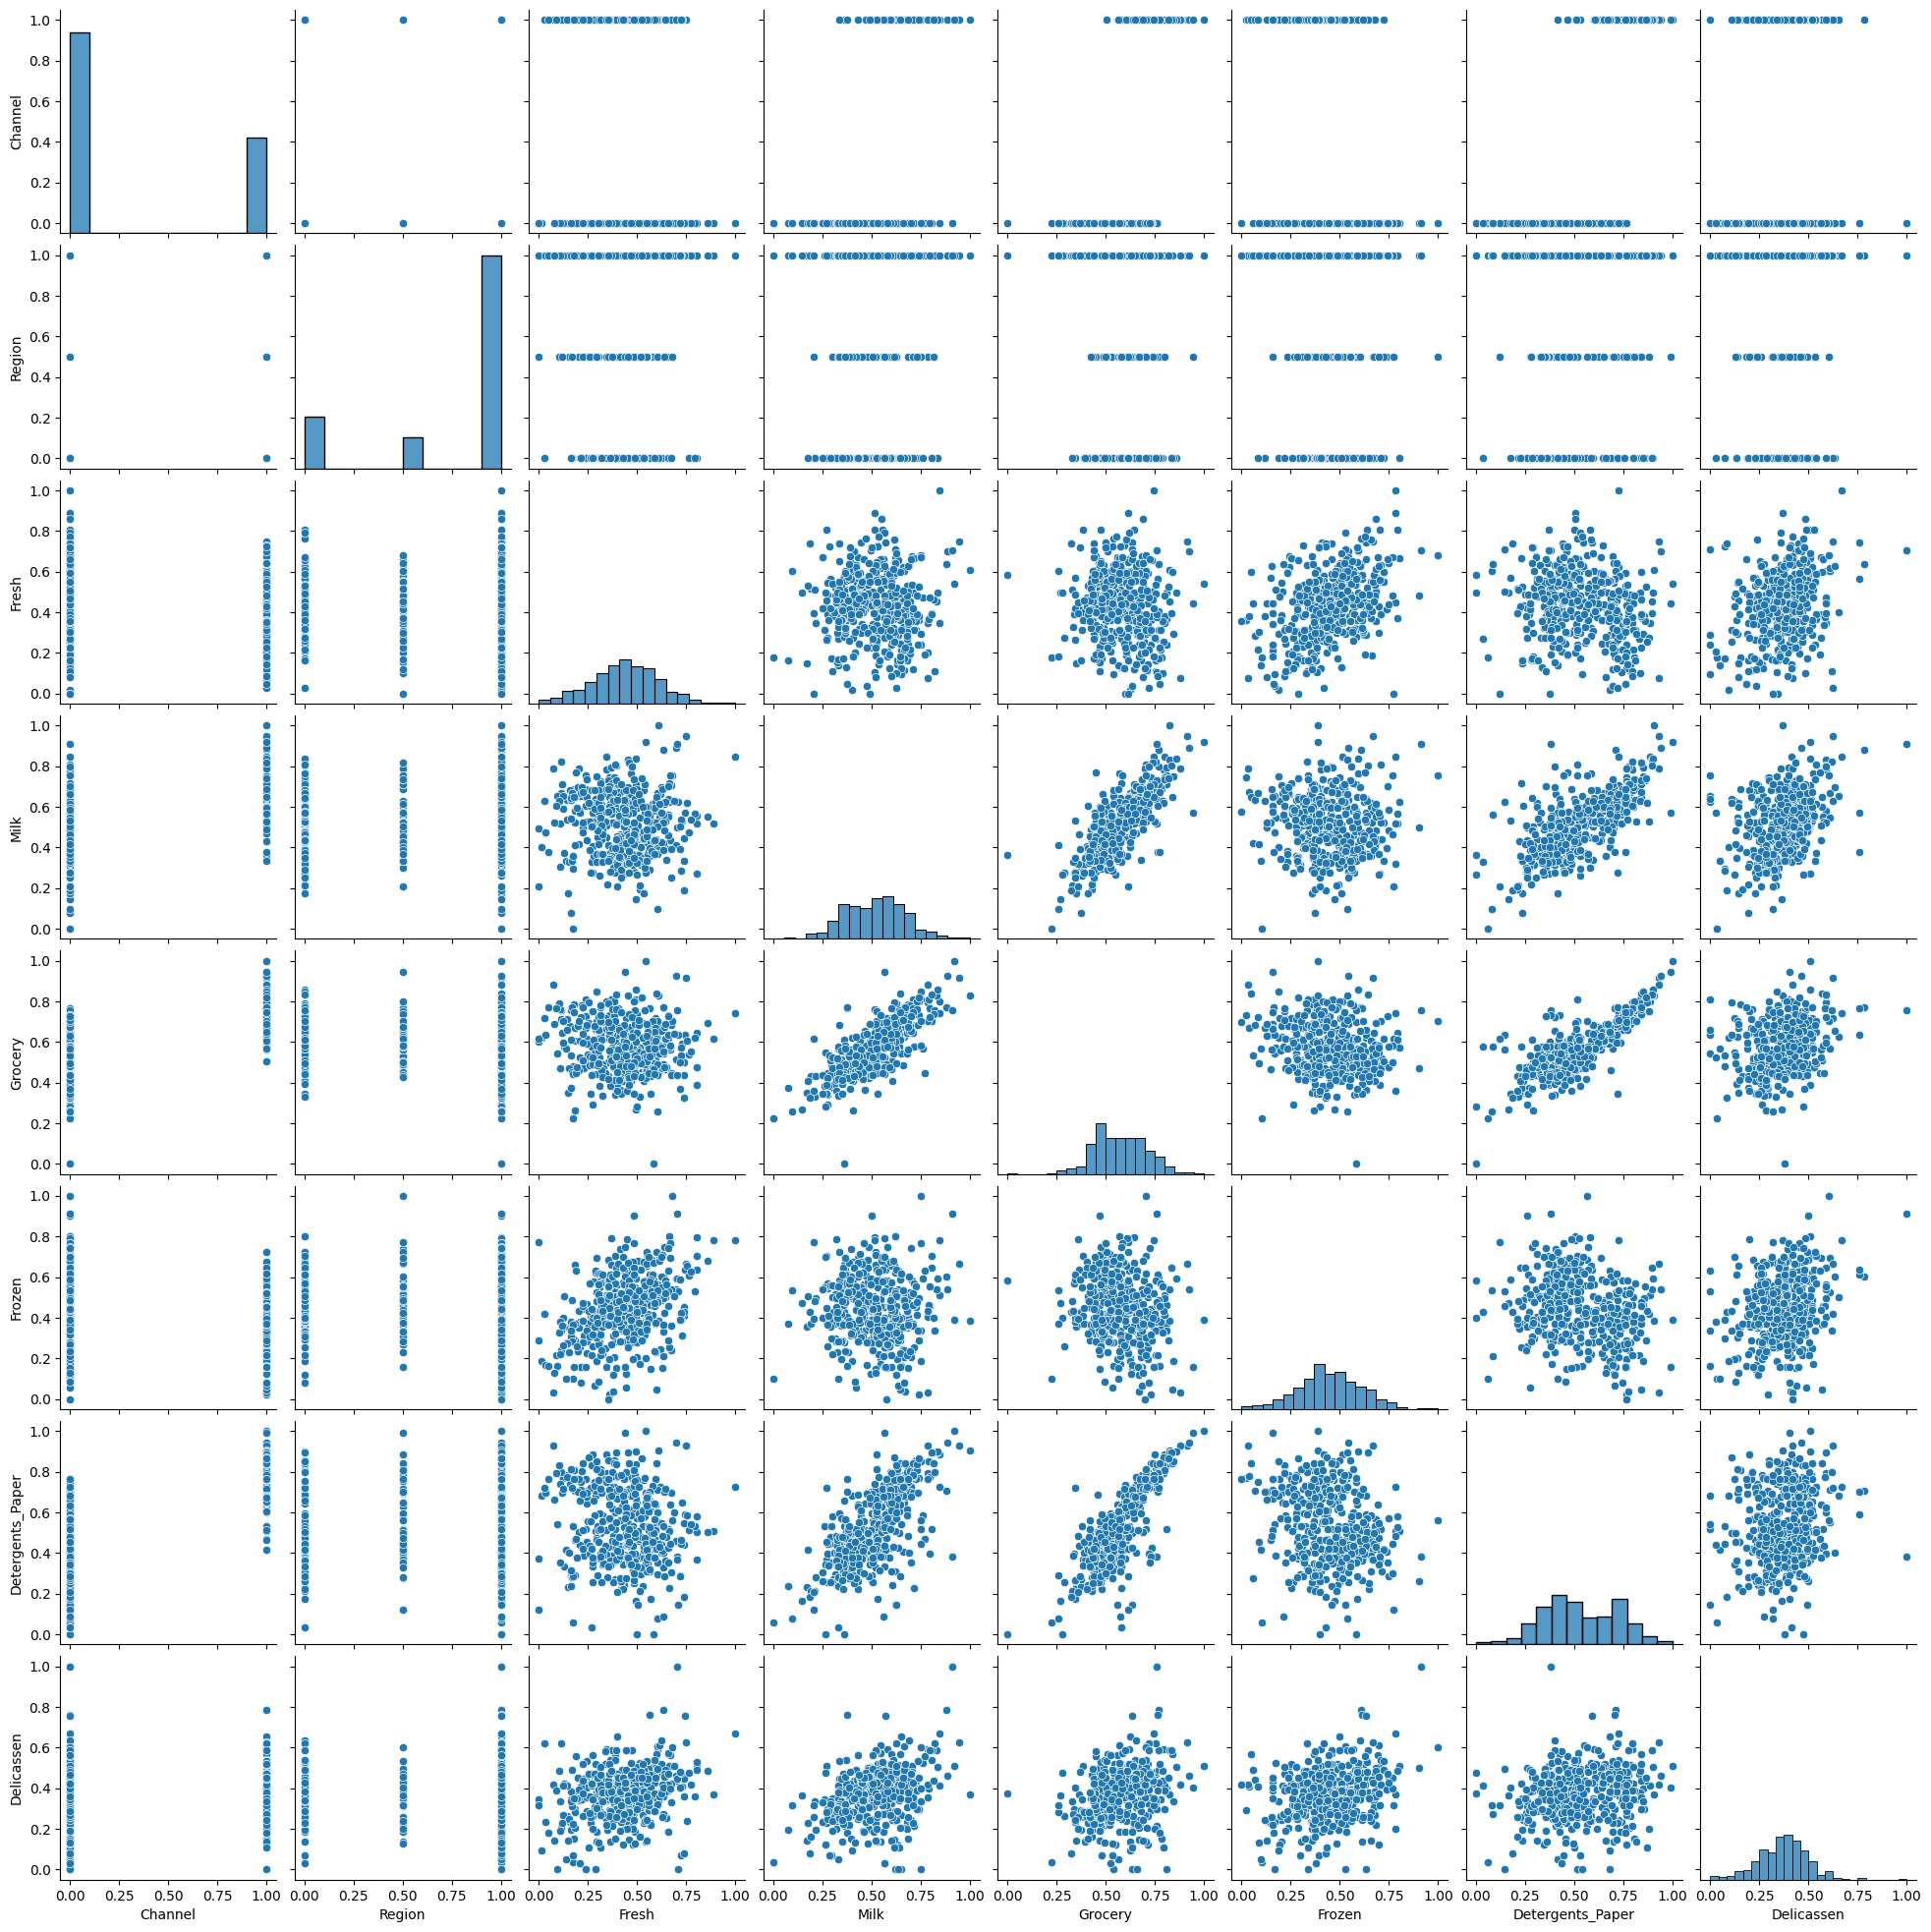

In [8]:
sns.pairplot(X);
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [9]:
k_range = list(range(2,11)) # set the range of k values to test 
parameters_km = [{'n_clusters': k_range}]
pg = list(ParameterGrid(parameters_km))
inertias_km = []
silhouette_scores_km = []
for i in range(len(pg)):
    km = KMeans(**(pg[i]), random_state=random_state)
    y_km = km.fit_predict(X)
    inertias_km.append(km.inertia_)
    silhouette_scores_km.append(silhouette_score(X,y_km))

## 4. Plot __inertia__ and __silhouette score__ versus `k`

In [10]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

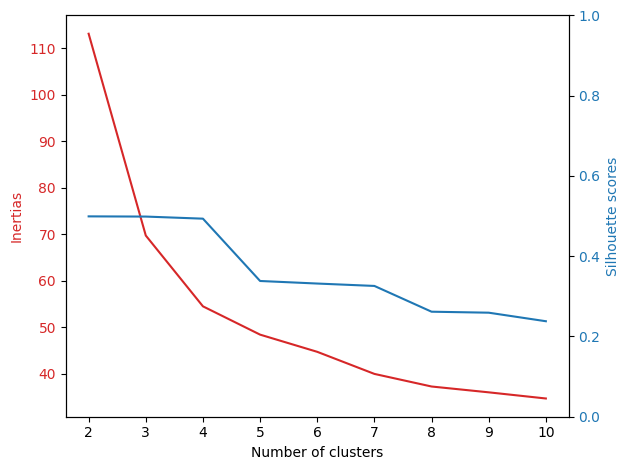

In [11]:
two_plots(x=k_range, y1=inertias_km, y2=silhouette_scores_km
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=4

In [12]:
k=4
km = KMeans(n_clusters=k, 
            random_state=random_state)
y_km = km.fit_predict(X)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,inertias_km[k_range.index(k)],silhouette_scores_km[k_range.index(k)]))

Number of clusters = 4	- Distortion =  54.49	- Silhouette score = 0.49


Show the distribution of samples in the clusters with a pie chart

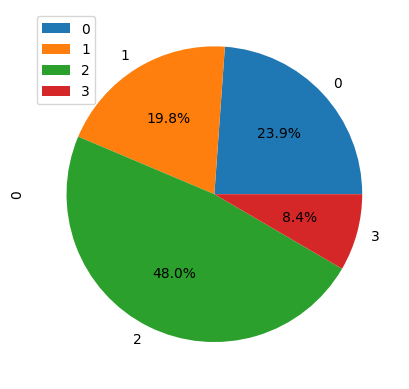

In [13]:
clust_sizes_km = np.unique(y_km,return_counts=True)
pd.DataFrame(clust_sizes_km[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Agglomerative clustering
We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

### Workflow:
- import AgglomerativeClustering
- prepare the parameter grid
- initialize a list for the results
- for each combination of results:
    - initialize the estimator with the appropriate combination of hyperparameters
    - fit the estimator and store the prediction to the variable y_ac
    - append to the result lists a triplet with the hyperparameter values and the silhouette score of the y_ac and the data
- create a dataframe from the result list and assign the appropriate column names
- sort the dataframe for descending silhouette scores and show it


In [14]:
parameters = [{'n_clusters': k_range
                    , 'linkage' : ['ward', 'complete', 'average', 'single']}]
pg = list(ParameterGrid(parameters))

In [15]:
### insert your code


In [16]:
from sklearn.cluster import AgglomerativeClustering
parameters = [{'n_clusters': k_range
                    , 'linkage' : ['ward', 'complete', 'average', 'single']}]
pg = list(ParameterGrid(parameters))
result_ac = []
for i in range(len(pg)):
    ac = AgglomerativeClustering(**(pg[i]))
    y_ac = ac.fit_predict(X)
    result_ac.append([pg[i]['linkage'],pg[i]['n_clusters'],silhouette_score(X,y_ac)])

In [17]:
df_result_ac = pd.DataFrame(data = result_ac, columns=['linkage','n_clusters','silhouette_score'])
df_result_ac.sort_values(by='silhouette_score', ascending=False)

linkage  n_clusters  silhouette_score
0       ward           2          0.499350
9   complete           2          0.499350
27    single           2          0.499350
18   average           2          0.499350
1       ward           3          0.498333
2       ward           4          0.493085
20   average           4          0.479507
11  complete           4          0.479507
21   average           5          0.475050
22   average           6          0.443867
23   average           7          0.429079
24   average           8          0.417343
33    single           8          0.402861
10  complete           3          0.402228
19   average           3          0.402228
13  complete           6          0.358410
12  complete           5          0.350571
34    single           9          0.349389
29    single           4          0.343557
28    single           3          0.343530
25   average           9          0.343345
3       ward           5          0.342252
26   average          10          0.338956
4       ward           6          0.333632
35    single          10          0.332562
5       ward           7          0.318470
30    single           5          0.292567
6       ward           8          0.285732
14  complete           7          0.280073
32    single           7          0.257306
7       ward           9          0.256243
8       ward          10          0.242371
15  complete           8          0.224454
31    single           6          0.212586
16  complete           9          0.185725
17  complete          10          0.166637

The top five results have a very similar silhouette score, we will choose the setting with 4 clusters, as for k-means, and the linkage giving the best result with 4 clusters, that is `ward`. This is the result record with `index 2` (the record index is the unnamed column at the very left of the dataframe output

In [18]:
print(df_result_ac.iloc[[2]])

  linkage  n_clusters  silhouette_score
2    ward           4          0.493085


In [19]:
ac = AgglomerativeClustering(**(pg[2]))
y_ac = ac.fit_predict(X)

Show the distribution of data in the clusters

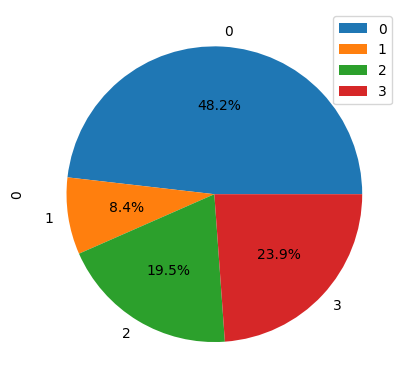

In [20]:
clust_sizes_ac = np.unique(y_ac,return_counts=True)
pd.DataFrame(clust_sizes_ac[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

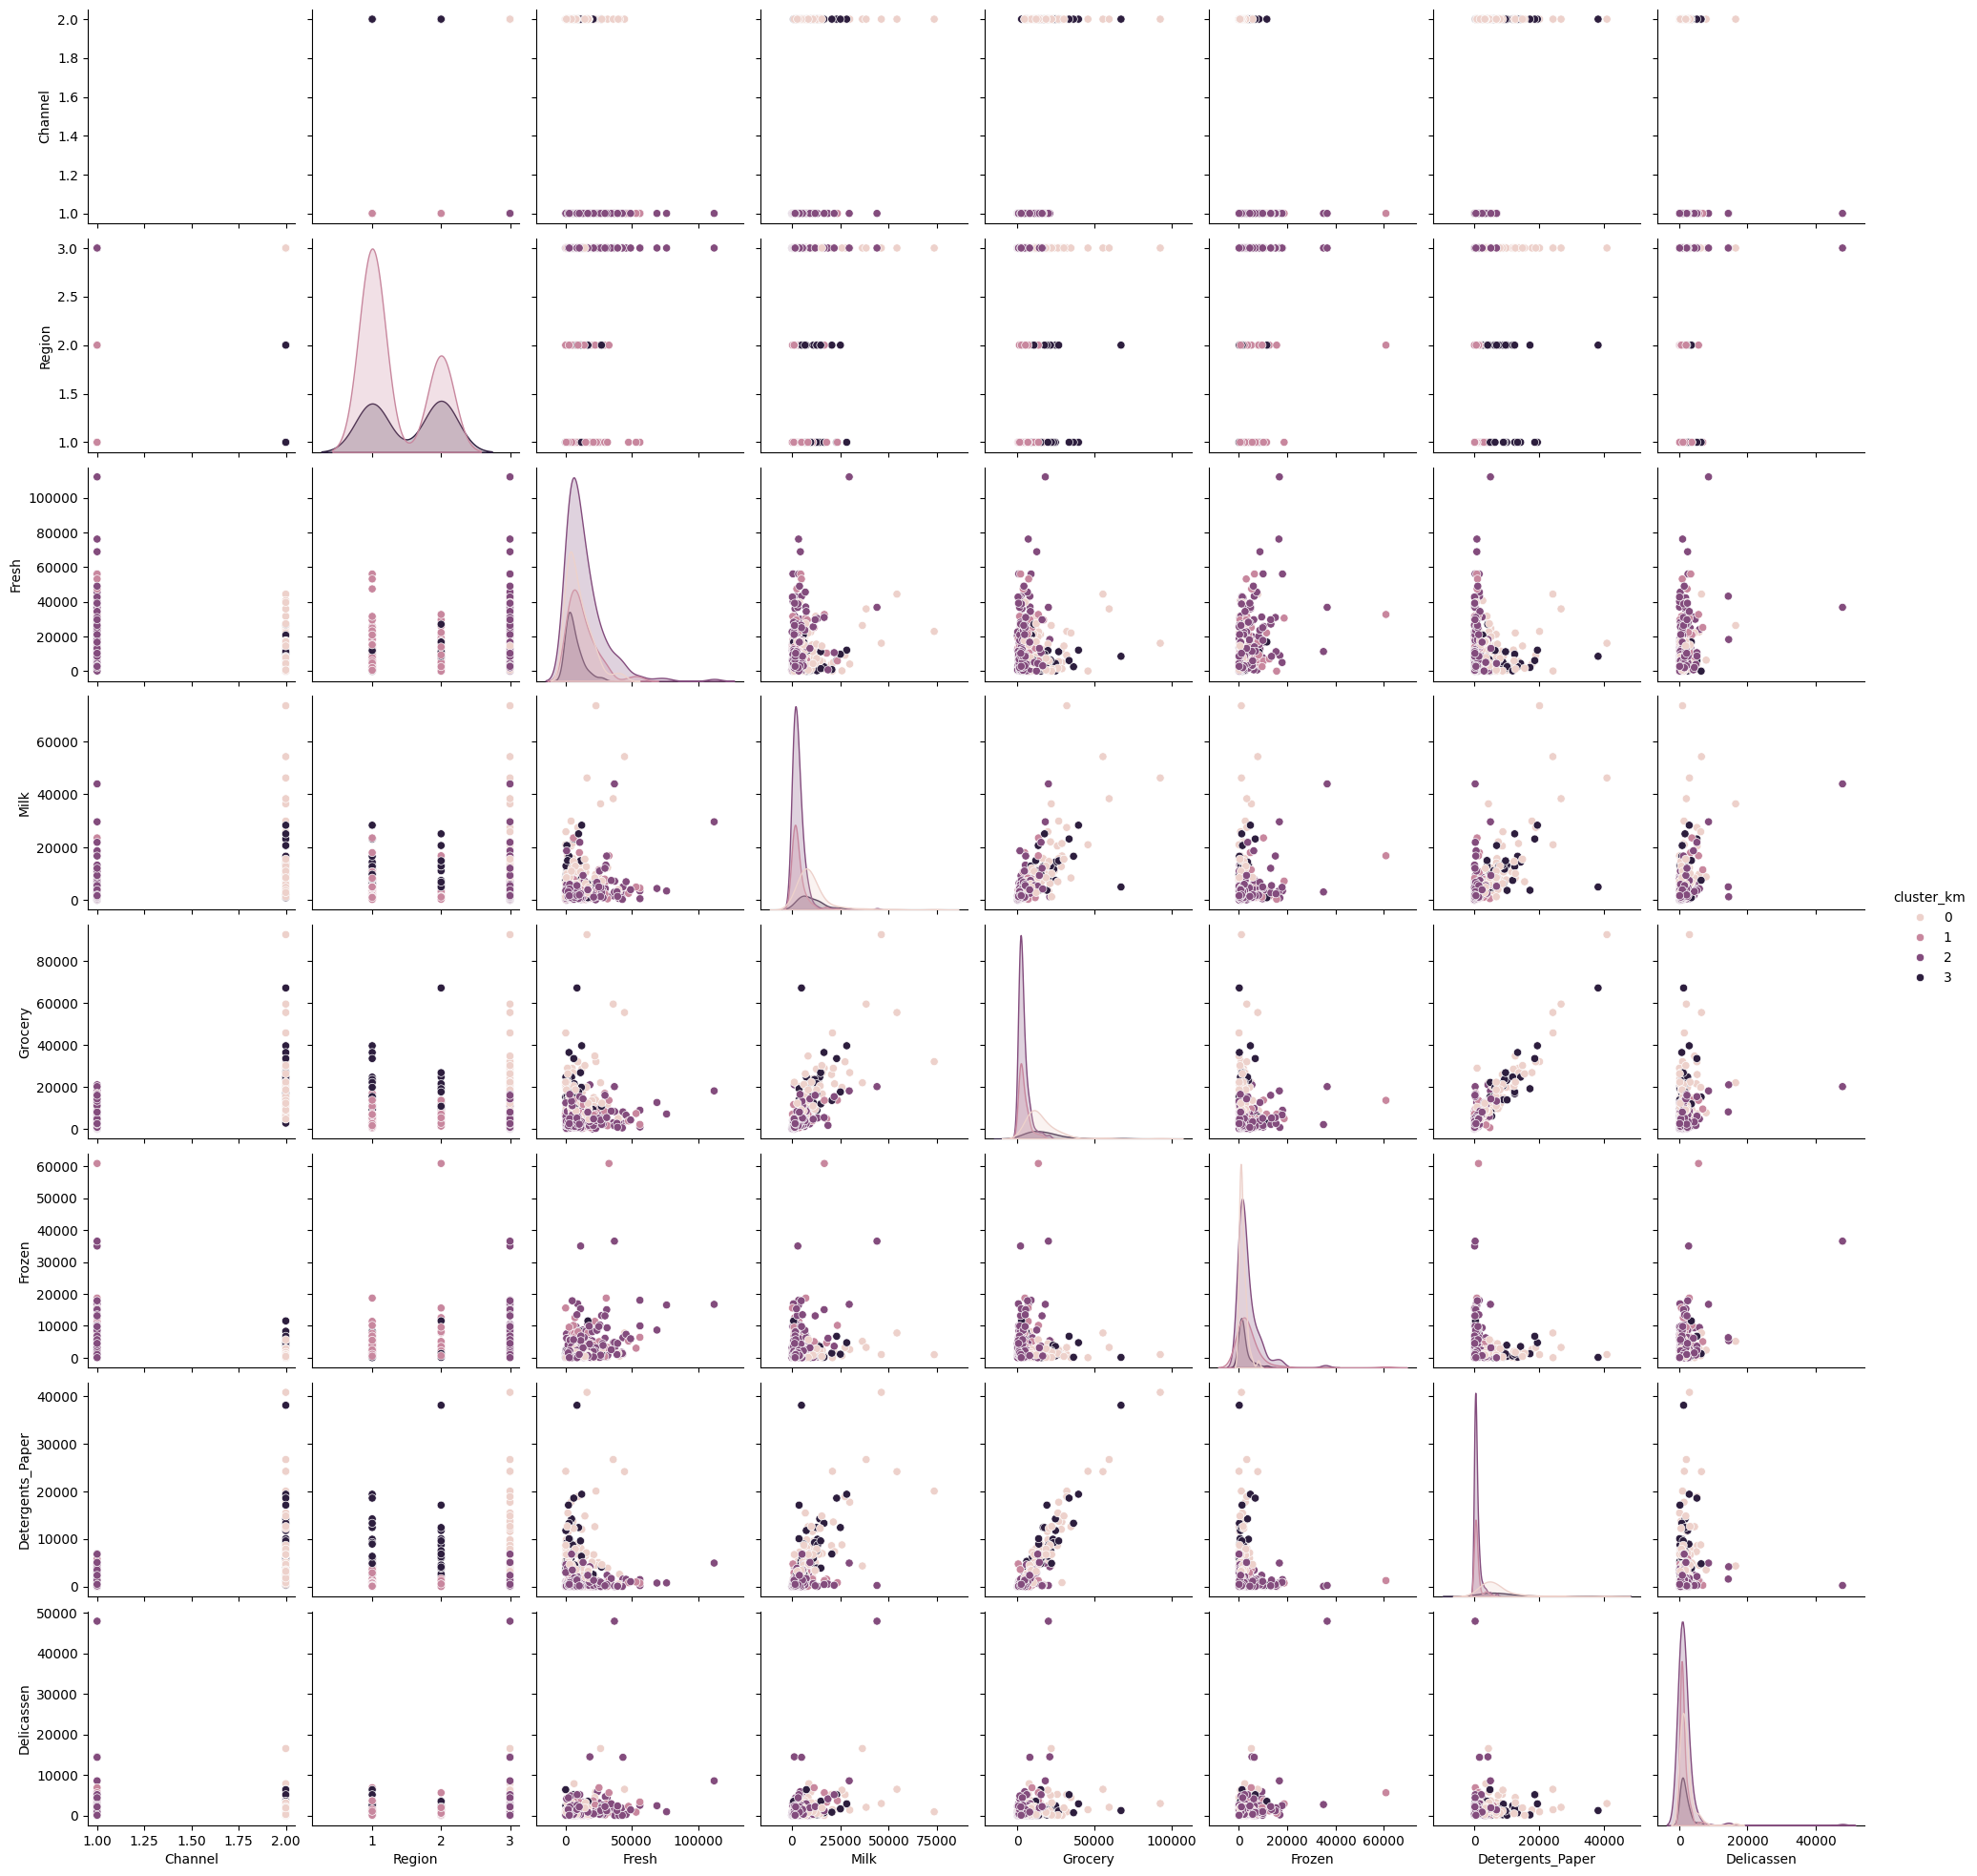

In [21]:
X0['cluster_km']=y_km
sns.pairplot(data=X0, hue='cluster_km');
plt.show()

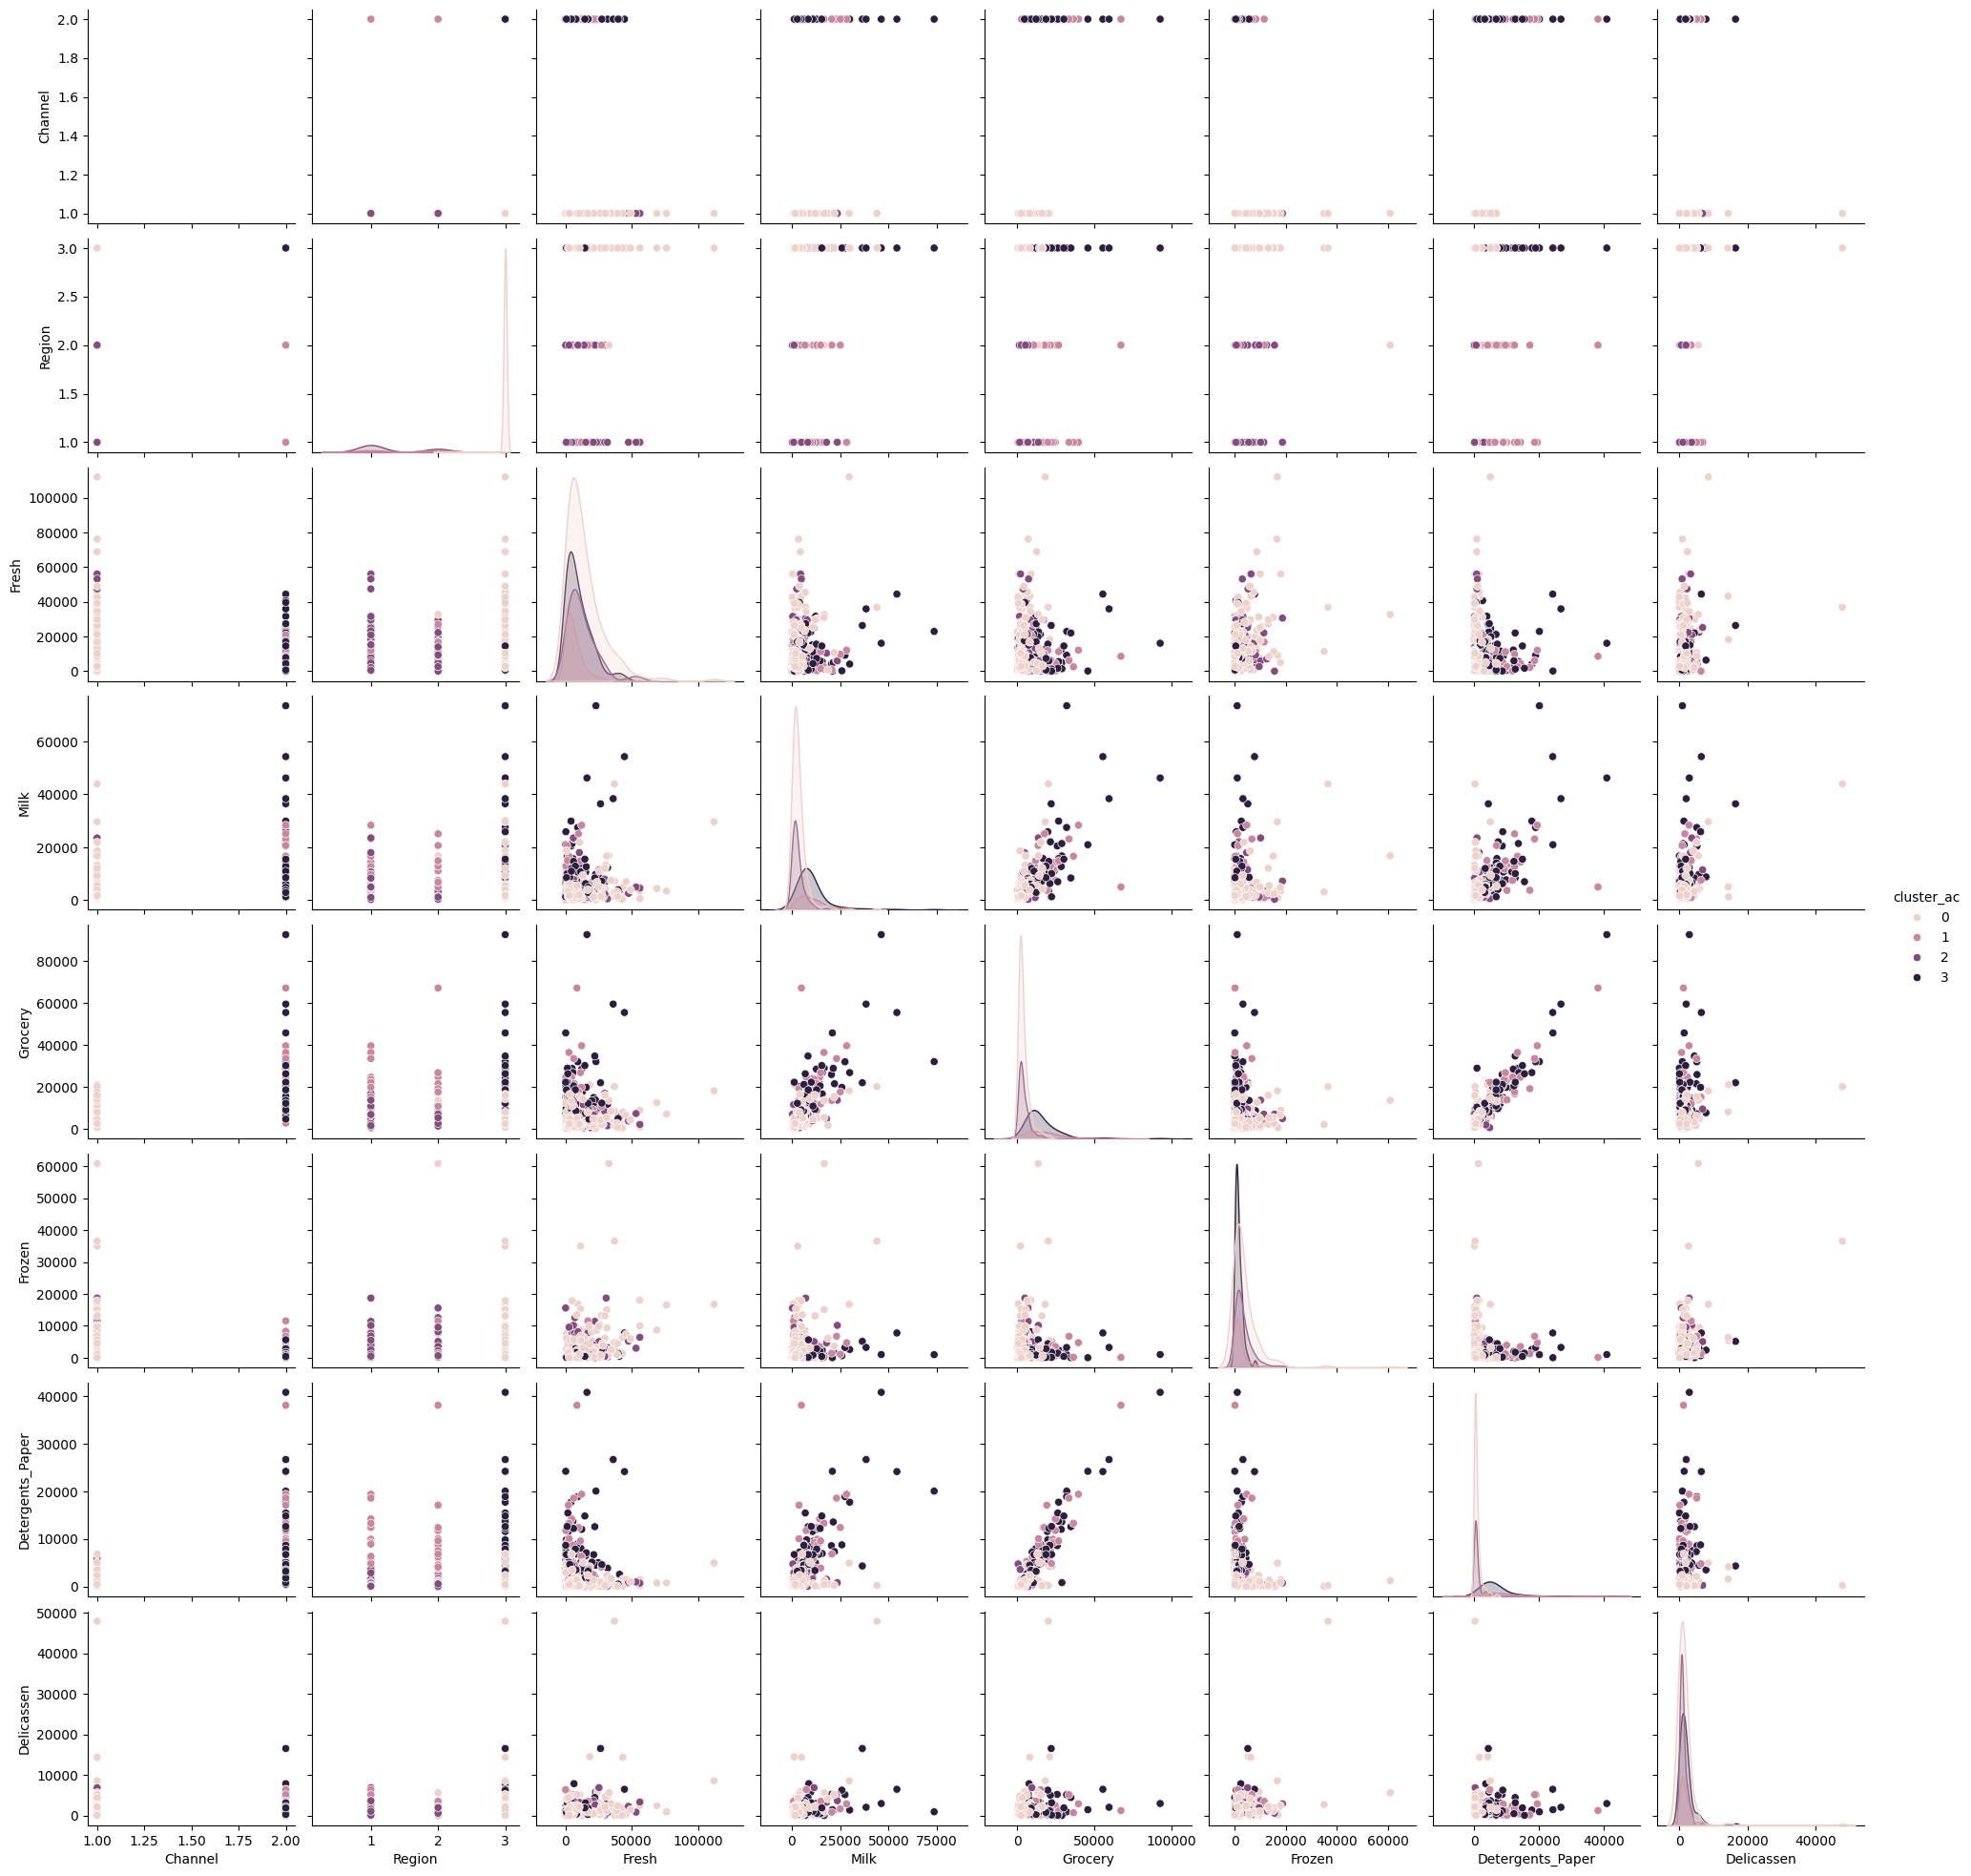

In [22]:
X0['cluster_ac']=y_ac
sns.pairplot(data=X0.drop('cluster_km',axis=1), hue='cluster_ac');
plt.show()

### Comments


The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the smaller the numbers out of the main diagona, the better the match.

For easier readability, we divide all the elements of the matrix by the sum of all the elements of the matrix, in this way, the matrix elements are normalized to 1.

In [23]:
from sklearn.metrics import pair_confusion_matrix
pcm = pair_confusion_matrix(y_km,y_ac)
pcm / pcm.sum()

array([[0.66625595, 0.00218472],
       [0.00089045, 0.33066888]])

A short indicator of the match percentage can be optained as a sum of the elements of the main diagonal.

In [24]:
print("The percentage of match between the two clustering schemes is {:6.2f}%"\
    .format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  99.69%


## DBSCAN

In [25]:
from sklearn.cluster import DBSCAN
db = DBSCAN()
y_db = db.fit_predict(X)

In [26]:
print("Default parameters - Eps={} - Min_Samples={}".format(db.eps,db.min_samples))

Default parameters - Eps=0.5 - Min_Samples=5


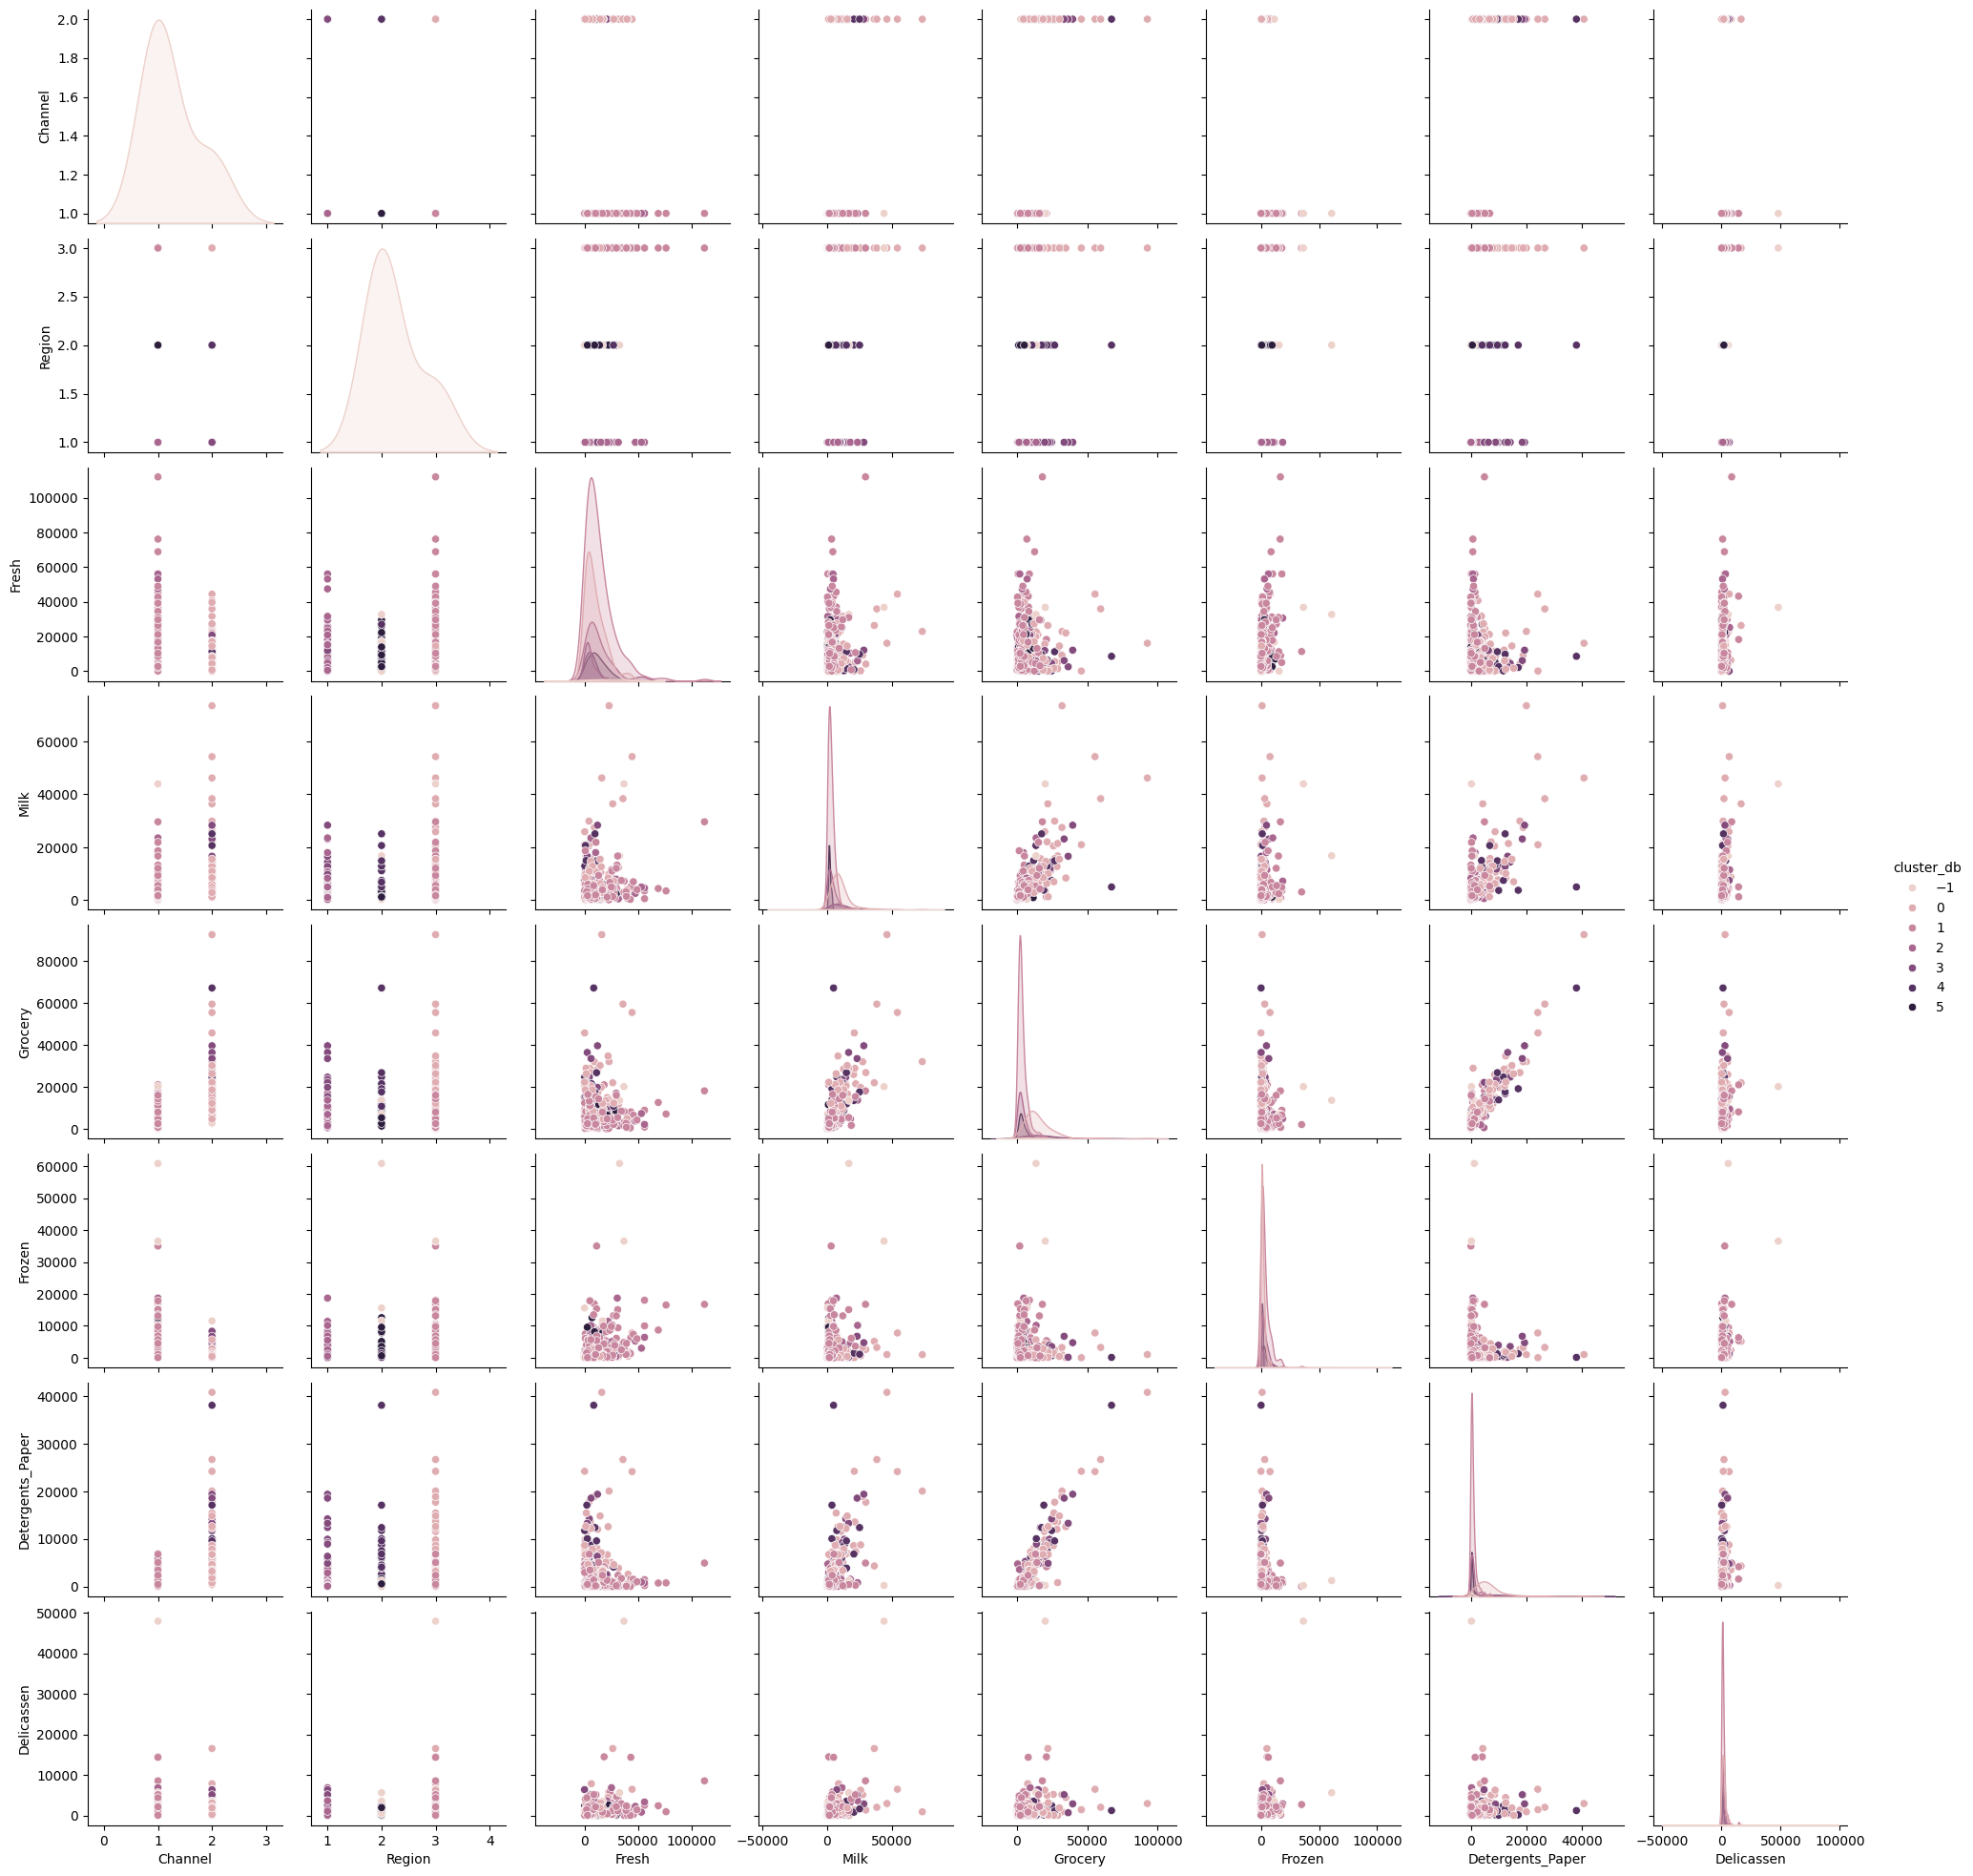

In [27]:
X0['cluster_db']=y_db
sns.pairplot(data=X0.drop(['cluster_km','cluster_ac'],axis=1), hue='cluster_db');
plt.show()

Show the distribution of data in the clusters

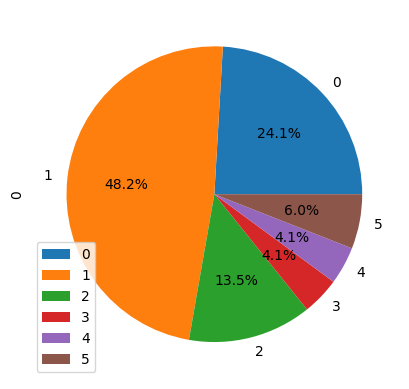

In [28]:
clust_sizes_db = np.unique(y_db[y_db!=-1],return_counts=True)
pd.DataFrame(clust_sizes_db[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

### 5. Find the best parameters using `ParameterGrid`

prepare the dictionary of the parameter ranges and produce the list of parameter settings to test with the function `ParameterGrid`

In [29]:
param_grid = {'eps': list(np.arange(0.001, 1, 0.005)), 'min_samples': list(range(2,10,1))}
params = list(ParameterGrid(param_grid))

Arrange DBSCAN results in a dataframe, for easier presentation and filtering

`dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])`

- for each parameter setting

In [30]:
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if 1 < n_clusters and n_clusters < len(y_db):
        X_cl = X.loc[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

In [31]:
sil_thr = 0.5  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
n_clu_max_thr = 5
dbscan_out[(dbscan_out['silhouette']>=sil_thr)\
         & (dbscan_out['unclust%']<=unc_thr)\
         & (dbscan_out['n_clusters']<=n_clu_max_thr)].sort_values(['silhouette','unclust%'],ascending=[False,True])

eps  min_samples  n_clusters  silhouette  unclust%
652  0.506          2.0         4.0    0.529010  0.909091
653  0.506          3.0         4.0    0.529010  0.909091
654  0.506          4.0         4.0    0.529010  0.909091
655  0.506          5.0         4.0    0.529010  0.909091
656  0.506          6.0         4.0    0.529010  0.909091
..     ...          ...         ...         ...       ...
743  0.561          5.0         2.0    0.500188  0.227273
744  0.561          6.0         2.0    0.500188  0.227273
745  0.561          7.0         2.0    0.500188  0.227273
746  0.561          8.0         2.0    0.500188  0.227273
747  0.561          9.0         2.0    0.500188  0.227273

[96 rows x 5 columns]

In [32]:
dbscan_out[(dbscan_out['n_clusters']==4)].sort_values(['silhouette','unclust%'],ascending=[False,True])

eps  min_samples  n_clusters  silhouette   unclust%
0    0.051          2.0         4.0    0.809127  98.181818
55   0.131          5.0         4.0    0.577401  75.681818
114  0.166          8.0         4.0    0.564877  59.090909
123  0.171          9.0         4.0    0.556483  57.500000
122  0.171          8.0         4.0    0.554163  55.454545
131  0.176          9.0         4.0    0.552283  54.772727
130  0.176          8.0         4.0    0.551633  53.181818
139  0.181          9.0         4.0    0.549653  53.863636
138  0.181          8.0         4.0    0.549119  51.590909
120  0.171          6.0         4.0    0.546914  49.545455
111  0.166          5.0         4.0    0.545816  50.681818
128  0.176          6.0         4.0    0.544325  46.363636
147  0.186          9.0         4.0    0.538980  50.000000
119  0.171          5.0         4.0    0.537250  46.590909
652  0.506          2.0         4.0    0.529010   0.909091
653  0.506          3.0         4.0    0.529010   0.909091
654  0.506          4.0         4.0    0.529010   0.909091
655  0.506          5.0         4.0    0.529010   0.909091
656  0.506          6.0         4.0    0.529010   0.909091
657  0.506          7.0         4.0    0.529010   0.909091
658  0.506          8.0         4.0    0.529010   0.909091
659  0.506          9.0         4.0    0.529010   0.909091
162  0.196          8.0         4.0    0.516842  37.727273
163  0.196          9.0         4.0    0.514844  41.136364
171  0.201          9.0         4.0    0.513659  39.318182
179  0.206          9.0         4.0    0.511789  36.363636
161  0.196          7.0         4.0    0.510886  35.909091
170  0.201          8.0         4.0    0.509058  35.909091
187  0.211          9.0         4.0    0.503088  34.090909
169  0.201          7.0         4.0    0.502949  34.545455
178  0.206          8.0         4.0    0.499673  33.181818
186  0.211          8.0         4.0    0.498606  32.954545
195  0.216          9.0         4.0    0.490289  32.045455
203  0.221          9.0         4.0    0.485615  29.772727
194  0.216          8.0         4.0    0.485379  30.454545
211  0.226          9.0         4.0    0.483599  28.181818
202  0.221          8.0         4.0    0.483369  28.409091
22   0.106          4.0         4.0    0.478732  91.590909
28   0.111          5.0         4.0    0.455728  92.045455
64   0.136          6.0         4.0    0.450831  77.045455
40   0.121          6.0         4.0    0.412454  90.000000
19   0.101          5.0         4.0    0.400643  95.454545
72   0.141          6.0         4.0    0.397130  71.818182
98   0.156          8.0         4.0    0.382141  69.318182
129  0.176          7.0         4.0    0.354982  49.318182
106  0.161          8.0         4.0    0.353064  67.045455
39   0.121          5.0         4.0    0.282229  87.045455

### 6. Observe  
- Observe visually the most promising combination of parameters reproducing the same number of clusters of the previous experiments 
- fit and predict the cluster labels and show a pairplot

In [33]:
best = {'eps':0.506, 'min_samples': 2}
# db = DBSCAN(**(params[db_best_par]))
db = DBSCAN(**best)
y_db = db.fit_predict(X)

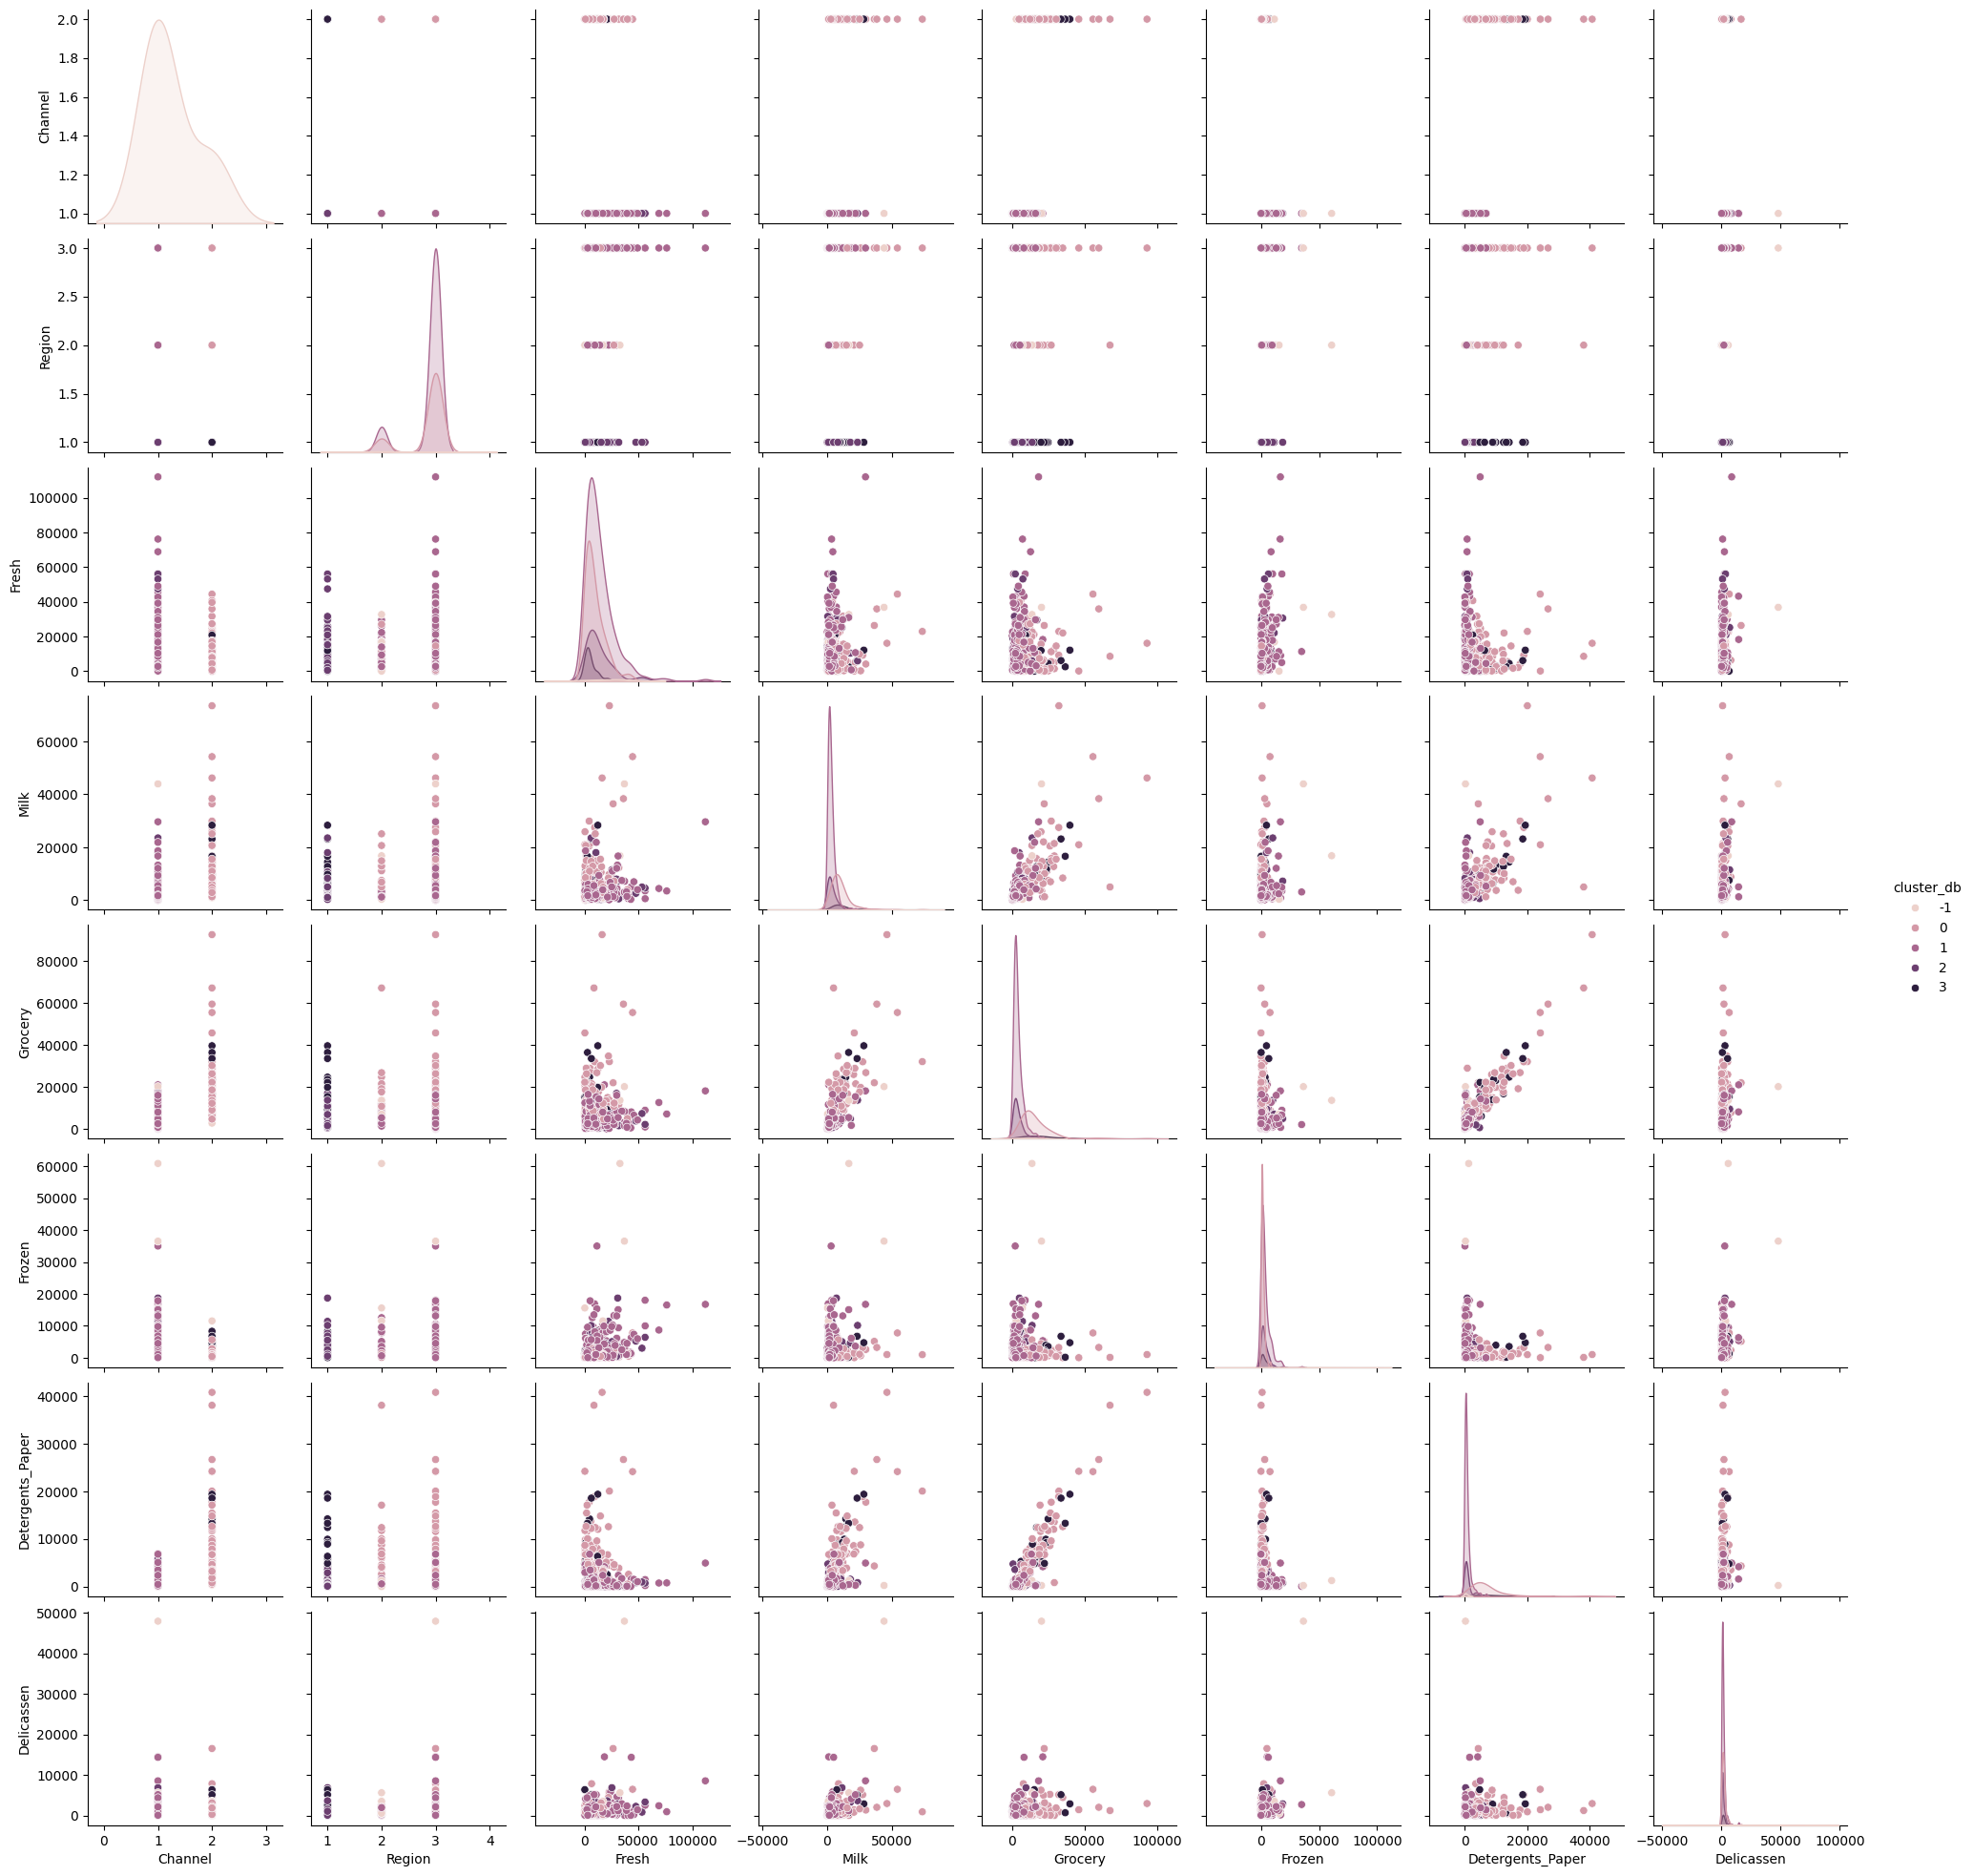

In [34]:
X0['cluster_db']=y_db
sns.pairplot(data=X0.drop(['cluster_km','cluster_ac'],axis=1), hue='cluster_db');
plt.show()

Show the cluster sizes

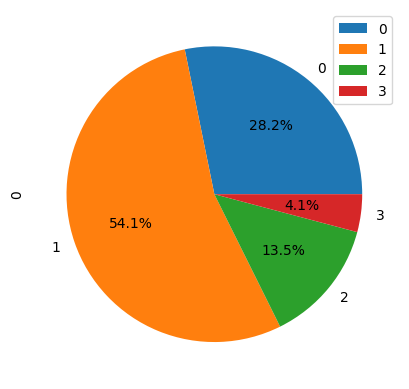

In [35]:
clust_sizes_db = np.unique(y_db[y_db!=-1],return_counts=True)
pd.DataFrame(clust_sizes_db[1]).plot.pie(y=0
                                         , autopct='%1.1f%%'
                                         );
plt.show()

## Silhouette plots

Use the function `plot_silhouette` contained in the module `plot_silhouette_w_mean` (provided with the notebook) and from `sklearn.metrics` import the function `silhouette_samples` providing the silhouette score for each sample

`from plot_silhouette_w_mean import plot_silhouette  # python script provided separately`

Hint: use `help(plot_silhouette)` for the meaning of the parameters

Hint: for DBSCAN you should exclude the rows of noise

In [36]:
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately
plt.title('KMeans')
silhouette = silhouette_samples(X,y_km)
plot_silhouette(silhouette,y_km)
plt.title('Agglomerative')
silhouette = silhouette_samples(X,y_ac)
plot_silhouette(silhouette,y_ac)
plt.title("DBSCAN")
silhouette = silhouette_samples(X.loc[y_db!=-1,:],y_db[y_db!=-1])
plot_silhouette(silhouette,y_db[y_db!=-1])

ModuleNotFoundError: No module named 'plot_silhouette_w_mean'

## Optional - Comparison with __boxplots__

For each of the clustering schemes show how the attribute values are distributed in the clusters

In [ ]:
plt.figure(figsize=(15,5))
plt.title('KMeans\n')
pos = 1
for i in X0.columns[0:8]:
    plt.subplot(2, 4, pos)
    plt.title(X0.columns[pos-1])
    plt.tight_layout()
    sns.boxplot(x=X0[i], y= X0['cluster_km'].astype('str')).set(xlabel=None)
    pos += 1
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Agglomerative')
pos = 1
for i in X0.columns[0:8]:
    plt.subplot(2, 4, pos)
    plt.title(X0.columns[pos-1])
    plt.tight_layout()
    sns.boxplot(x=X0[i], y= X0['cluster_ac'].astype('str')).set(xlabel=None)
    pos += 1
plt.show()

In [ ]:
X0_c = X0.loc[X0['cluster_db']!=-1].copy()
plt.figure(figsize=(15,5))
plt.title('DBSCAN\n')
pos = 1
for i in X0.columns[0:8]:
    plt.subplot(2, 4, pos)
    plt.title(X0.columns[pos-1])
    plt.tight_layout()
    sns.boxplot(x=X0_c[i], y= X0_c['cluster_db'].astype('str')).set(xlabel=None)
    pos += 1
plt.show()

## Control questions
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results